### SVR(Support Vector Regression)은 SVM을 회귀 적용 모델
##### SVM(Soft Vector Machine)SVR SVM 서포트 벡터 머신의 변형 모델. 
* SVM은 데이터 포인트를 분류에 사용 적합,
* SVR은 목표 데이터 포인트가 최대 허용 오차 이내에 있도록 하며, 
포인트가 가까워지도록 만드는 것이 핵심. 연속적인 값을 예측하는하는데 사용 적합.

In [21]:
from IPython.display import display, HTML as HTML_display
html_content = f'''
<div style="border: 3px solid red; border-radius: 10px; padding: 20px; background-color: #f9f9f9;">
    <h2 style="color: #000;"><strong>SVR model inside an SVM model</strong></h2>

    <h3 style="color: #000;"><strong>5개 비교지표 SVR모델</strong></h3>
    <ul>
        <li style="color: #000;"><strong>stock_df:</strong>'sc_date', 'sc_ss_stock': 날짜 , 삼성주가</li>
        <li style="color: #000;"><strong>main_economic:</strong>'mei_date', 'mei_gold', 'mei_sp500', 'mei_kospi' : 날짜 , 금가, S&P500, 코스피 </li>
        <li style="color: #000;"><strong>korea_economic:</strong> 'kei_date', 'kei_m2_avg', 'kei_fr' : 날짜, M2통화공급(평잔),외환보유액</li>
    </ul>

    <h3 style="color: #000;"><strong>DATA</strong></h3>
    <ul>
        <li style="color: #000;"> <strong>Total Data: 3614</strong></li>
        <li style="color: #000;"><strong>X_train</strong> 학습 데이터(8) : 2891 (피처 값) </li>
        <li style="color: #000;"><strong>X_test</strong> 테스트 데이터(2) : 723 (피처 값)</li>
        <li style="color: #000;"><strong>y_train</strong> : 723 (타겟 값)</li>
        <li style="color: #000;"><strong>y_train_pred, y_test_pred:</strong> 예측 값</li>
        <li style="color: #000;"><strong>data: </strong>날짜 및 종가를 포함한 데이터프레임</li>
    </ul>

    <h3 style="color: #000;"><strong>Grid-search</strong></h3>
    <ul>
        <li style="color: #000;"> <strong>'C': 1500</strong></li>
        <li style="color: #000;"><strong>'epsilon': 0.01</strong> </li>
        <li style="color: #000;"><strong>'gamma': 0.01</strong></li>
        <li style="color: #000;"><strong>'kernel': 'rbf'</strong></li>

    </ul>

    <h3 style="color: #000;">Performance Metrics</h3>
    <ul>
        <li style="color: #000;"><strong>Mean Squared Error (MSE):</strong> {mse:.4f}</li>
        <li style="color: #000;"><strong>Root Mean Squared Error (RMSE):</strong>{rmse:.4f} </li>
        <li style="color: #000;"><strong>Mean Absolute Error (MAE):</strong>{mae:.4f} </li>
        <li style="color: #000;"> <strong>Decision Coefficient (R<sup>2</sup>):</strong>{r2:.4f} </li>
    </ul>

    <h3 style="color:#000;">Model Status</h3>
    <p style="color: #000;"><strong>과적합 가능성: 모델이 학습 데이터에 비해 테스트 데이터에서 성능이 낮음.</strong></p>

<h2 style="color:#4CAF50;"><strong>에로사항</strong></h2>
<P style="color: #000;">
    <strong><스케일링></strong></br>
    standard스켈라를 사용하면, 스켈링중에서 표준편차를 이용했기때문에 전처리가 과적합된다. </br>
    하지만 min max를 사용하면, 스케일링에서 [0,1]의 범위내에서 스켈링 되기 때문에 이전 이미지가 흘러내리는 것이 방지된다.</br>  
    하지만, min max이용시 역변을 하여야 한다 이는 => 스켈링값 그대로 가져오기 때문이다. </br>
    역변환을 해서 원래 값으로 복원해야 한다. inverse_transform 메서드를 사용할 수 있다.</br>
</br>
    <strong><파라미터 : 정규화></strong>
    C 범위를 최대치로 끓어 올려, 학습 데이터에 더 강하게 맞춤. </br>
    작을수록 학습데이터는 일반화 된다.</br>
</br>
<strong><전처리 강화></strong>
    차원 축소 PCA 적용 후 시도해본 바 r2값이 오히려 낮춰졌다.</br>
</br>
<strong><교차검증></br></strong>
    폴드 추가 cv=5 에서 10으로 변경해봤으나 값은 같았다.  </P>

</div>
'''
display(HTML_display(html_content))

### 1. 라이브러리

In [22]:
import joblib                                            # 모델 저장 및 로드를 위한 라이브러리
import numpy as np                                       # 수치 계산을 위한 라이브러리
import pandas as pd                                      # 데이터 처리 및 조작을 위한 라이브러리
import seaborn as sns                                    # 데이터 시각화를 위한 라이브러리
from datetime import datetime, timedelta                 # 날짜 및 시간 계산을 위한 라이브러리
import matplotlib.pyplot as plt                          # 데이터 시각화를 위한 라이브러리
import matplotlib.dates as mdates                        # 날짜 포맷팅을 위한 라이브러리

# 머신러닝 관련 라이브러리
from sklearn.svm import SVR                              # Support Vector Regression (SVR) 모델
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score  # 성능 평가 지표
from sklearn.preprocessing import StandardScaler         # 데이터 스케일링을 위한 라이브러리
from sklearn.linear_model import LinearRegression        # 선형 회귀 모델
from sklearn.model_selection import train_test_split, GridSearchCV  # 데이터 분할 및 하이퍼파라미터 튜닝

# 경고 무시 (StandardScaler와 관련된 경고 메시지를 무시)
import warnings
warnings.filterwarnings("ignore", message="X does not have valid feature names, but StandardScaler was fitted with feature names")

### 2. 데이터 불러오기 및 전처리

In [23]:
stock_df          = pd.read_excel('tb_stock.xlsx')
main_economic     = pd.read_excel('tb_main_economic_index.xlsx')
korea_economic    = pd.read_excel('tb_korea_economic_indicator.xlsx')

stock_df          = stock_df[['sc_date', 'sc_ss_stock']]
main_economic     = main_economic[['mei_date', 'mei_gold', 'mei_sp500', 'mei_kospi']]
korea_economic    = korea_economic[['kei_date', 'kei_m2_avg', 'kei_fr']]

# 날짜 열 이름 통일
stock_df.rename(columns={'sc_date' :'date'}, inplace=True)
main_economic.rename(columns={'mei_date' :'date'}, inplace=True)
korea_economic.rename(columns={'kei_date' :'date'}, inplace=True)

merged_df         = pd.merge(stock_df, main_economic, on='date', how='inner')               # 주식 데이터와 주요 경제 지표 데이터 병합
merged_df         = pd.merge(merged_df, korea_economic, on='date', how='inner')             # 위에서 병합한 데이터에 한국 경제 지표 데이터 추가 병합

data = merged_df

# 시계열 데이터 전처리
data['MA_7'] = data['sc_ss_stock'].rolling(window=7).mean()                                 # 7일 이동 평균 계산
                                                                                            # (주가의 단기적 추세를 관찰하기 위해 7일 간의 주가의 평균값을 계산하여 새로운 열로 추가)
                                                                                            # 이동 평균은 시계열 데이터에서 잡음을 줄이고 주가의 기본적인 방향을 쉽게 볼 수 있도록 해줌.

data['Diff'] = data['sc_ss_stock'].diff()                                                   # 주가의 차분 계산
                                                                                            # (현재 주가에서 이전 주가를 빼서 하루 간의 주가 변동량을 계산하여 새로운 열로 추가)
                                                                                            # 차분은 시계열 데이터의 추세(trend)와 계절성(seasonality)을 제거하고, 
                                                                                            # 데이터의 정적 성질(stationarity)을 확인하는 데 사용됨.

data = data.dropna()                                                                        # 결측치가 있는 행 제거
                                                                                            # (이동 평균과 차분을 계산하면서 발생하는 NaN 값이 있는 행을 제거하여 데이터 정리)
                                                                                            # 이 단계는 모델 학습에 영향을 줄 수 있는 결측치를 제거하기 위해 필요.


### 3. 데이터 분할 및 정규화

In [24]:
X       = data.drop(['sc_ss_stock', 'date'], axis=1)                                        # 피처와 타겟 변수 분리 (날짜 컬럼 제외)
y       = data['sc_ss_stock']

print(f"전체 데이터 수: {X.shape[0]}")                                                       

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, shuffle=False)

print(f"학습 데이터 수: {X_train.shape[0]}")
print(f"테스트 데이터 수: {X_test.shape[0]}")

print(f'X_train shqpe : {X_train.shape}, y_train shape : {y_train.shape}')
print(f'X_test shqpe : {X_train.shape}, y_test shape : {y_train.shape}')

scaler  = StandardScaler()                                                                  
X_train = scaler.fit_transform(X_train)
X_test  = scaler.transform(X_test)

전체 데이터 수: 3614
학습 데이터 수: 2891
테스트 데이터 수: 723
X_train shqpe : (2891, 7), y_train shape : (2891,)
X_test shqpe : (2891, 7), y_test shape : (2891,)


### 4. 그리드 서치

In [50]:
# 3. 모델 학습 및 튜닝 (그리드서치 최적의 파라미터 찾기)
svr = SVR()

param_grid = {
    'C': [100, 500, 1000, 1500],                                                            # C 값은 모델의 규제 강도를 결정합니다. 
                                                                                            # 값이 클수록 학습 데이터에 더 잘 맞추려 하지만 과적합의 위험이 커집니다.
                                                                                            # 값이 작을수록 모델은 더 단순해져서 과적합을 방지하고, 일반화 성능이 높아질 수 있습니다.
                                                                                            # 여기서는 100, 500, 1000, 1500의 값들을 시도하여 최적의 규제 강도를 찾습니다.
    
    'gamma': ['scale', 'auto', 0.0001, 0.001, 0.01],                                        # gamma 값은 RBF 커널 함수의 영향을 받는 범위를 결정합니다.
                                                                                            # 'scale'은 1 / (n_features * X.var())로 설정되어, 데이터의 분산에 비례한 값을 사용합니다.
                                                                                            # 'auto'는 1 / n_features로 설정되어, 특성의 개수에 반비례하는 값을 사용합니다.
                                                                                            # 숫자 값들은 고정된 gamma 값을 의미하며, 작은 값일수록 모델이 넓은 범위의 데이터에 반응하게 되고, 
                                                                                            # 큰 값일수록 좁은 범위에 민감하게 반응합니다.
                                                                                            # 'scale', 'auto', 0.0001, 0.001, 0.01의 값들을 시도하여 최적의 값을 찾습니다.
    
    'kernel': ['rbf'],                                                                      # kernel은 데이터의 비선형성을 처리하기 위한 함수입니다.
                                                                                            # 'rbf'는 Radial Basis Function 커널로, 비선형 데이터를 고차원 공간으로 매핑하여 
                                                                                            # 복잡한 패턴을 학습할 수 있습니다.
                                                                                            # 이 그리드 서치에서는 'rbf' 커널만 사용합니다.

    'epsilon': [0.10, 0.5, 0.05, 0.01]                                                      # epsilon 값은 SVR 모델에서 예측 오차의 허용 범위를 설정합니다.
                                                                                            # 모델은 epsilon 값 내의 오차를 허용하며, 그 외의 오차에 대해서만 패널티를 부과합니다.
                                                                                            # 작은 epsilon 값은 모델이 작은 오차에도 민감하게 반응하도록 하고, 
                                                                                            # 큰 epsilon 값은 오차를 더 많이 허용합니다.
                                                                                            # 0.10, 0.5, 0.05, 0.01의 값들을 시도하여 최적의 오차 허용 범위를 찾습니다.
}

grid_search = GridSearchCV(svr, param_grid, cv=5, scoring='r2') 
grid_search.fit(X_train, y_train)

best_svr = grid_search.best_estimator_
print(f"최적의 파라미터: {grid_search.best_params_}")

최적의 파라미터: {'C': 1500, 'epsilon': 0.01, 'gamma': 0.01, 'kernel': 'rbf'}


### 5. 모델 평가(성능)

In [51]:
y_pred = best_svr.predict(X_test)                                                           # 테스트 데이터(X_test)에 대해 훈련된 최적의 서포트 벡터 회귀(SVR) 모델(best_svr)을 사용해 예측값(y_pred)을 생성
                                                                                            # 이 단계에서는 훈련된 모델이 새로운 데이터를 입력받아 출력(예측값)을 생성합니다.
                                                                                            # 이 예측값은 실제 값과 비교되어 모델의 성능을 평가하는 데 사용됩니다.

mse = mean_squared_error(y_test, y_pred)                                                    # 실제 값(y_test)과 모델이 예측한 값(y_pred) 사이의 평균 제곱 오차(MSE)를 계산
                                                                                            # MSE는 각 예측 오차(실제 값과 예측 값의 차이)를 제곱한 후, 그 평균을 구한 값입니다.
                                                                                            # 값이 작을수록 모델의 예측이 실제 값에 더 가깝다는 것을 의미합니다.
                                                                                            # 제곱을 사용하기 때문에, 큰 오차가 더 크게 반영됩니다.

r2 = r2_score(y_test, y_pred)                                                               # 실제 값(y_test)과 예측 값(y_pred) 사이의 결정 계수(R^2 스코어)를 계산하여 모델의 설명력을 평가
                                                                                            # R^2 스코어는 모델이 데이터를 얼마나 잘 설명하는지를 나타내는 지표로, 1에 가까울수록 모델이 데이터를 잘 설명한다는 의미입니다.
                                                                                            # R^2는 전체 분산 중에서 모델이 설명하는 비율을 나타내며, 0이면 모델이 전혀 설명하지 못함을 의미합니다.

mae = mean_absolute_error(y_test, y_pred)                                                   # 실제 값(y_test)과 예측 값(y_pred) 사이의 평균 절대 오차(MAE)를 계산
                                                                                            # MAE는 각 예측 오차의 절대값을 평균한 값으로, 예측 오차의 평균적인 크기를 나타냅니다.
                                                                                            # 값이 작을수록 모델의 예측이 실제 값에 더 가깝다는 것을 의미합니다.
                                                                                            # 절대값을 사용하기 때문에 오차의 부호는 무시됩니다.

rmse = mean_squared_error(y_test, y_pred, squared=False)                                    # 평균 제곱 오차(MSE)의 제곱근을 취해 루트 평균 제곱 오차(RMSE)를 계산
                                                                                            # RMSE는 MSE의 제곱근으로, 예측 오차를 원래 데이터와 같은 단위로 표현합니다.
                                                                                            # 이는 MSE보다 해석이 쉬운 지표이며, 큰 오차에 더 민감하게 반응합니다.
                                                                                            # RMSE는 모델의 전반적인 성능을 평가하는 데 유용합니다.


y_train_pred = best_svr.predict(X_train)
train_mse    = mean_squared_error(y_train, y_train_pred)
train_r2     = r2_score(y_train, y_train_pred)

print(f"\n학습 데이터 평가:")
print(f"학습 데이터셋에 대한 모델의 성능을 평가 (MSE): {train_mse}")
print(f"학습 데이터셋에 대한 모델의 성능을 평가 결정 계수 값 (R^2): {train_r2}")

performance_gap = train_r2 - r2                                                             # 학습 데이터셋과 테스트 데이터셋의 성능 차이 계산

print("\n모델 평가:")
if performance_gap > 0.2:
    print("과적합 가능성: 모델이 학습 데이터에 비해 테스트 데이터에서 성능이 낮음.")
elif train_r2 < 0.8 and r2 < 0.8:
    print("과소적합 가능성: 모델이 학습 데이터와 테스트 데이터 모두에서 성능이 낮음.")
elif train_r2 >= 0.8 and r2 >= 0.8:
    print("모델이 잘 일반화되었습니다: 학습 데이터와 테스트 데이터 모두에서 높은 성능을 보임.")
else:
    print("예외적인 상황: 학습 데이터의 성능이 낮으나, 테스트 데이터의 성능이 높은 경우입니다. 일반적으로는 드문 상황입니다.")

C:\Users\mys11\AppData\Roaming\Python\Python311\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


테스트 데이터 평가:
오차 제곱 평균(mse): 17999033.648047257
테스트 결정 계수 값 (R^2): 0.7199244638230817
절대적 오차 (MAE): 3017.588044878032
평균의 제곱근을 취한 값 (RMSE): 4242.526799920922

학습 데이터 평가:
학습 데이터셋에 대한 모델의 성능을 평가 (MSE): 1758384.4476653275
학습 데이터셋에 대한 모델의 성능을 평가 결정 계수 값 (R^2): 0.9943866528866566

모델 평가:
과적합 가능성: 모델이 학습 데이터에 비해 테스트 데이터에서 성능이 낮음.


최적의 파라미터: {'C': 1500, 'epsilon': 0.01, 'gamma': 'auto', 'kernel': 'rbf'}


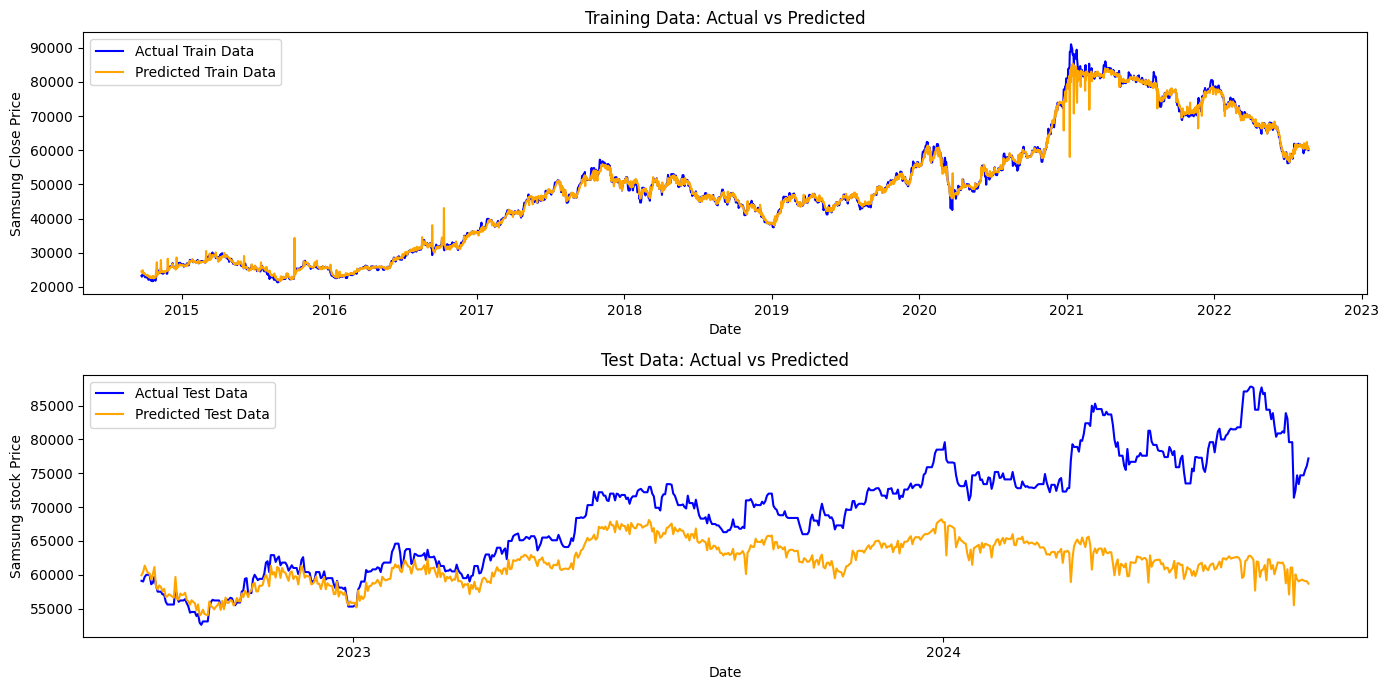

In [52]:
# GridSearchCV를 사용한 하이퍼파라미터 튜닝
grid_search = GridSearchCV(svr, param_grid, cv=tscv, scoring='r2', n_jobs=-1)                   # SVR 모델(svr)에 대해 그리드 서치(GridSearchCV)를 사용해 하이퍼파라미터 튜닝 수행
                                                                                                # param_grid: 탐색할 하이퍼파라미터 값들의 범위가 정의된 딕셔너리
                                                                                                # cv: 교차 검증을 위한 TimeSeriesSplit 객체(tscv), 시계열 데이터의 특성을 반영하여 데이터 분할
                                                                                                # scoring: 모델의 성능을 평가할 메트릭으로 결정 계수(R^2)를 사용
                                                                                                # n_jobs: 병렬 처리를 위해 사용할 CPU 코어 수를 지정, -1은 모든 가용 코어를 사용

grid_search.fit(X_train, y_train)                                                               # 그리드 서치 수행, X_train과 y_train 데이터를 사용해 여러 하이퍼파라미터 조합을 평가하여 최적의 모델을 찾음

# 최적 모델 선택
best_svr = grid_search.best_estimator_                                                          # 그리드 서치를 통해 선택된 최적의 하이퍼파라미터를 가진 SVR 모델(best_svr)을 추출
print(f"최적의 파라미터: {grid_search.best_params_}")                                            # 최적의 하이퍼파라미터 조합을 출력하여 확인

# 재학습된 모델로 예측 수행
y_train_pred = best_svr.predict(X_train)                                                        # 최적의 모델을 사용해 훈련 데이터(X_train)에 대한 예측 수행
y_test_pred = best_svr.predict(X_test)                                                          # 최적의 모델을 사용해 테스트 데이터(X_test)에 대한 예측 수행

# 예측 값의 스케일 복원 (필요한 경우)
if 'y_scaler' in locals():                                                                      # y_scaler 객체가 존재할 경우, 예측 값과 실제 값에 대한 스케일 복원을 수행
y_train_pred = y_scaler.inverse_transform(y_train_pred.reshape(-1, 1)).flatten()                # 훈련 데이터 예측 값(y_train_pred)의 스케일을 원래대로 복원
y_test_pred = y_scaler.inverse_transform(y_test_pred.reshape(-1, 1)).flatten()                  # 테스트 데이터 예측 값(y_test_pred)의 스케일을 원래대로 복원
y_train = y_scaler.inverse_transform(y_train.values.reshape(-1, 1)).flatten()                   # 훈련 데이터 실제 값(y_train)의 스케일을 원래대로 복원
y_test = y_scaler.inverse_transform(y_test.values.reshape(-1, 1)).flatten()                     # 테스트 데이터 실제 값(y_test)의 스케일을 원래대로 복원


# 시각화
plt.figure(figsize=(14, 7))

# 학습 데이터 시각화
plt.subplot(2, 1, 1)
plt.plot(data['date'].iloc[:len(y_train)], y_train, label='Actual Train Data', color='blue')
plt.plot(data['date'].iloc[:len(y_train)], y_train_pred, label='Predicted Train Data', color='orange')
plt.title('Training Data: Actual vs Predicted')
plt.xlabel('Date')
plt.ylabel('Samsung Close Price')
plt.legend()
plt.gca().xaxis.set_major_locator(mdates.YearLocator())
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y'))

# 테스트 데이터 시각화
plt.subplot(2, 1, 2)
plt.plot(data['date'].iloc[len(y_train):], y_test, label='Actual Test Data', color='blue')
plt.plot(data['date'].iloc[len(y_train):], y_test_pred, label='Predicted Test Data', color='orange')
plt.title('Test Data: Actual vs Predicted')
plt.xlabel('Date')
plt.ylabel('Samsung stock Price')
plt.legend()
plt.gca().xaxis.set_major_locator(mdates.YearLocator())
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y'))

plt.tight_layout()
plt.show()


### 6. 시각화 (학습, 테스트)

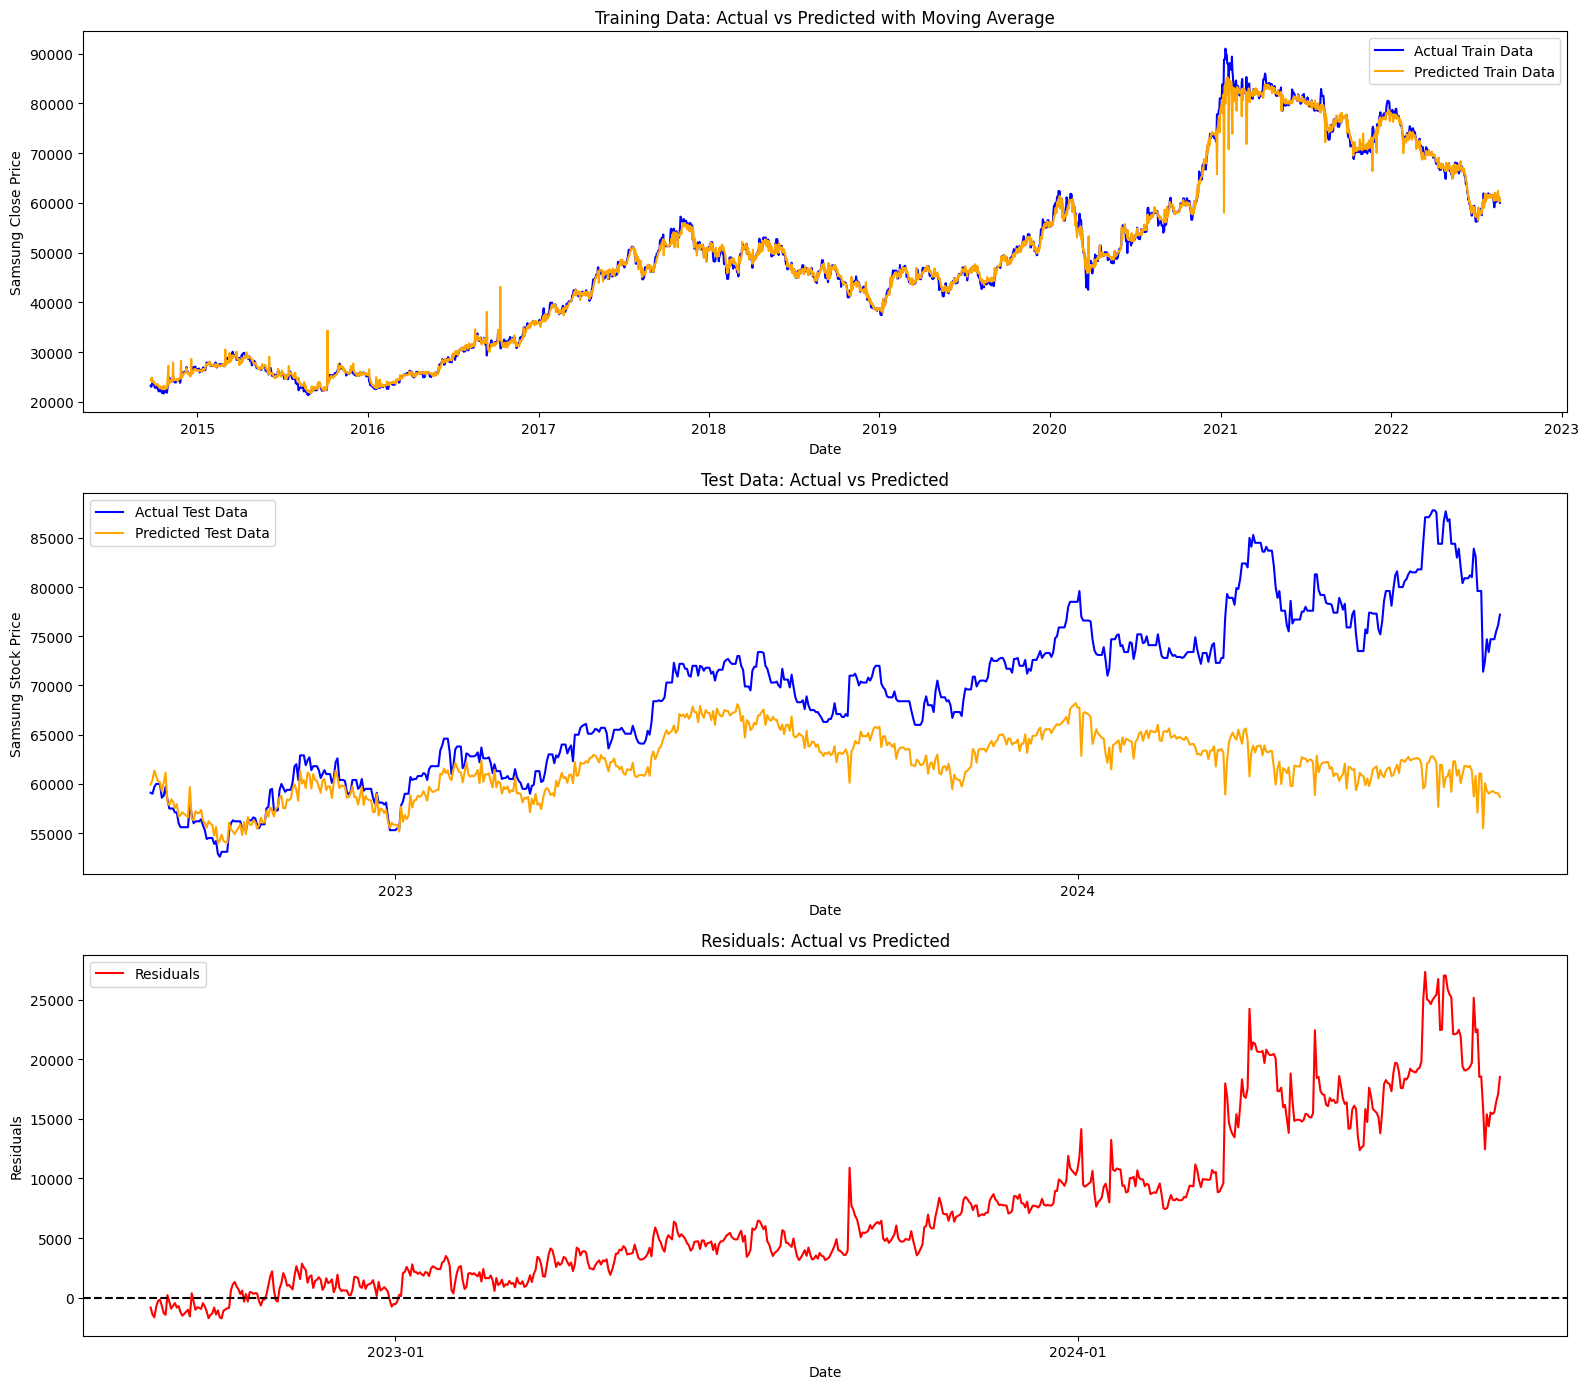

In [53]:
data['date'] = pd.to_datetime(data['date'], errors='coerce')                                    # 'date' 열의 데이터를 날짜 형식으로 변환
                                                                                                # pd.to_datetime: 판다스의 함수를 사용하여 문자열 또는 숫자 형식의 데이터를 날짜 및 시간 형식으로 변환
                                                                                                # data['date']: 변환할 대상인 'date' 열
                                                                                                # errors='coerce': 변환할 수 없는 값이 있을 경우, 오류를 발생시키지 않고 NaT(Not a Time)로 처리
                                                                                                # 이 옵션은 잘못된 데이터로 인한 에러를 피하고, 추후 NaT 값을 처리할 수 있게 함


data = data.dropna(subset=['date'])

# 학습 데이터와 테스트 데이터에 대한 예측
y_train_pred = best_svr.predict(X_train)
y_test_pred  = best_svr.predict(X_test)

# 학습 데이터 시각화
plt.figure(figsize=(16, 14))

# 학습 데이터 시각화
plt.subplot(3, 1, 1)  
plt.plot(data['date'].iloc[:len(y_train)], y_train.values, label='Actual Train Data', color='blue')
plt.plot(data['date'].iloc[:len(y_train)], y_train_pred, label='Predicted Train Data', color='orange')
plt.title('Training Data: Actual vs Predicted with Moving Average')
plt.xlabel('Date')
plt.ylabel('Samsung Close Price')
plt.legend()

# x축에 연도만 표시
plt.gca().xaxis.set_major_locator(mdates.YearLocator())
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y'))

plt.subplot(3, 1, 2)                                                                                                            
plt.plot(data['date'].iloc[len(y_train):], y_test.values, label='Actual Test Data', color='blue')
plt.plot(data['date'].iloc[len(y_train):], y_test_pred, label='Predicted Test Data', color='orange')
plt.title('Test Data: Actual vs Predicted')
plt.xlabel('Date')
plt.ylabel('Samsung Stock Price')
plt.legend()

plt.gca().xaxis.set_major_locator(mdates.YearLocator())                                                                            
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y'))

residuals   = y_test - y_test_pred                                                               # 잔차 분석
plt.subplot(3, 1, 3)                                                                             # 3행 1열의 세 번째 subplot
plt.plot(data['date'].iloc[len(y_train):], residuals, label='Residuals', color='red')
plt.axhline(0, color='black', linestyle='--')                                                                
plt.title('Residuals: Actual vs Predicted')
plt.xlabel('Date')
plt.ylabel('Residuals')
plt.legend()

plt.gca().xaxis.set_major_locator(mdates.YearLocator())                                          # x축에 연도만 표시
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))

plt.tight_layout()
plt.show()

### 7. 예측값 테스트

In [55]:
from datetime import timedelta                                                                  # timedelta 모듈을 사용해 날짜와 시간을 더하거나 뺄 때 사용
import numpy as np                                                                              # 숫자 계산을 위한 numpy 라이브러리
import pandas as pd                                                                             # 데이터 처리와 분석을 위한 pandas 라이브러리
import matplotlib.pyplot as plt                                                                 # 데이터 시각화를 위한 matplotlib 라이브러리
import matplotlib.dates as mdates                                                               # 날짜 포맷팅을 위한 matplotlib의 dates 모듈

# 4주 예측 학습
last_train_date = data['date'].iloc[len(y_train) - 1]                                           # 훈련 데이터의 마지막 날짜를 추출
                                                                                                # data['date']: 전체 데이터셋에서 'date' 열을 선택
                                                                                                # len(y_train) - 1: 훈련 데이터의 길이를 이용해 마지막 인덱스를 계산
                                                                                                # iloc: 데이터프레임에서 위치 기반 인덱싱을 사용하여 날짜를 추출

# 4주 후 예측 날짜 계산
prediction_date = last_train_date + timedelta(weeks=4)                                          # 마지막 훈련 날짜에 4주를 더해 예측 날짜를 계산
                                                                                                # timedelta(weeks=4): 4주를 나타내는 timedelta 객체를 생성

# 마지막 데이터 포인트 추출 및 데이터프레임 생성
last_test_data = X_test[-1:]                                                                    # 테스트 데이터에서 마지막 데이터 포인트를 추출
last_test_df = pd.DataFrame(last_test_data, columns=X.columns)                                  # 마지막 데이터 포인트를 사용해 데이터프레임 생성
                                                                                                # columns=X.columns: 원본 데이터의 열 이름을 유지

# 스케일링 적용
input_scaled = scaler.transform(last_test_df)                                                   # 스케일링된 데이터로 변환
                                                                                                # scaler.transform: 학습된 스케일러를 사용해 마지막 테스트 데이터를 변환

# 예측 수행 (학습된 best_svr 모델 사용)
predicted_value = best_svr.predict(input_scaled)                                                # 최적의 SVR 모델(best_svr)을 사용해 예측 값 생성

# 예측된 값 확인
print(f"예측된 값 (원본): {predicted_value}")                                                    # 예측된 값을 출력해 확인

# 예측된 값이 음수일 경우 0으로 변경
predicted_value = np.maximum(predicted_value, 0)                                                # 예측된 값이 음수일 경우 0으로 변경하여 논리적 결과 보장
                                                                                                # np.maximum: 각 원소별로 0과 비교해 큰 값을 반환

# 예측된 값의 형태를 확인하고 필요할 경우 형식을 변경
if predicted_value.ndim == 1:                                                                   # 예측된 값이 1차원 배열일 경우 2차원으로 변환
    predicted_value = predicted_value.reshape(-1, 1)                                            # reshape(-1, 1): 1차원 배열을 2차원 열 벡터로 변환

# 예측된 값의 스케일 복원 (필요한 경우, 예: StandardScaler를 적용한 경우)
# y_scaler가 적용되었다면:
# predicted_value = y_scaler.inverse_transform(predicted_value)                                 # 예측 값의 스케일을 원래대로 복원 (필요한 경우에만)

# 결과 출력
print(f"마지막 학습 날짜: {last_train_date}")                                                    # 마지막 학습 날짜를 출력
print(f"예측 날짜 (4주 후): {prediction_date}")                                                  # 예측한 날짜(4주 후)를 출력
print(f"예측된 삼성전자 종가: {predicted_value[0][0]:.2f}")                                       # 예측된 삼성전자 종가를 소수점 둘째 자리까지 출력


# 결과 출력
print(f"마지막 학습 날짜: {last_train_date}")
print(f"예측 날짜 (4주 후): {prediction_date}")
print(f"예측된 삼성전자 종가: {predicted_value[0][0]:.2f}")


예측된 값 (원본): [55487.09332457]
마지막 학습 날짜: 2022-08-22 00:00:00
예측 날짜 (4주 후): 2022-09-19 00:00:00
예측된 삼성전자 종가: 55487.09


### 8. 결과 시각화

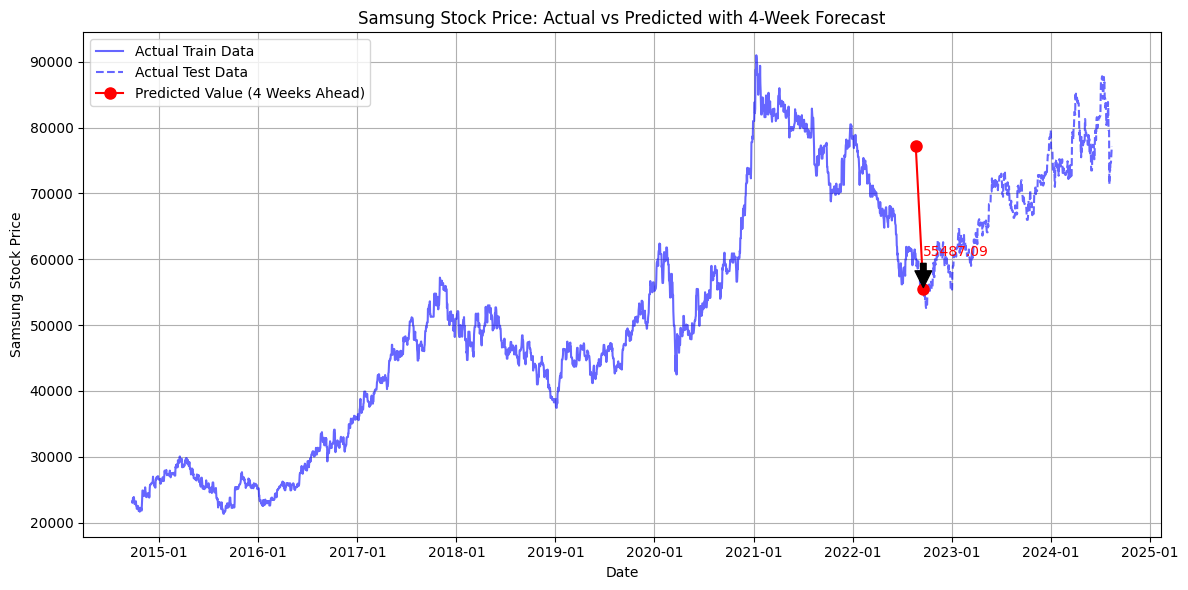

In [46]:
# 예측된 값의 시각화 (과거 데이터 포함)
plt.figure(figsize=(12, 6))

# 학습 데이터와 테스트 데이터 시각화
plt.plot(data['date'].iloc[:len(y_train)], y_train.values, label='Actual Train Data', color='blue', linestyle='-', alpha=0.6)
plt.plot(data['date'].iloc[len(y_train):], y_test.values, label='Actual Test Data', color='blue', linestyle='--', alpha=0.6)

# 4주 후 예측 값 시각화
plt.plot([last_train_date, prediction_date],                                                    # x축에 사용할 두 개의 날짜 (마지막 학습 날짜와 예측 날짜)
        [data['sc_ss_stock'].iloc[-1], predicted_value[0][0]],                                  # y축에 사용할 두 개의 값 (마지막 실제 값과 예측 값)
        marker='o', markersize=8, color='red', label='Predicted Value (4 Weeks Ahead)')         # 플롯 스타일 지정: 빨간색 원형 마커로 표시

plt.annotate(f'{predicted_value[0][0]:.2f}',                                                    # 주석에 예측 값을 텍스트로 표시
        xy=(prediction_date, predicted_value[0][0]),                                            # 주석을 표시할 위치 (예측 날짜, 예측 값)
        xytext=(prediction_date, predicted_value[0][0] + 5000),                                 # 텍스트를 표시할 위치 조정 (y축에서 5000 단위 위로)
        arrowprops=dict(facecolor='black', shrink=0.05),                                        # 주석에 화살표 스타일 지정: 검은색 화살표와 축소 설정
                fontsize=10, color='red')                                                       # 주석 텍스트의 폰트 크기와 색상 지정 (빨간색)


# 그래프 설정
plt.title('Samsung Stock Price: Actual vs Predicted with 4-Week Forecast')
plt.xlabel('Date')
plt.ylabel('Samsung Stock Price')
plt.legend()
plt.grid(True)
plt.gca().xaxis.set_major_locator(mdates.YearLocator())
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))

plt.tight_layout()
plt.show()

마지막 학습 날짜: 2022-08-22 00:00:00
예측 날짜 (4주 후): 2022-09-19 00:00:00
예측된 삼성전자 종가: 55487.09


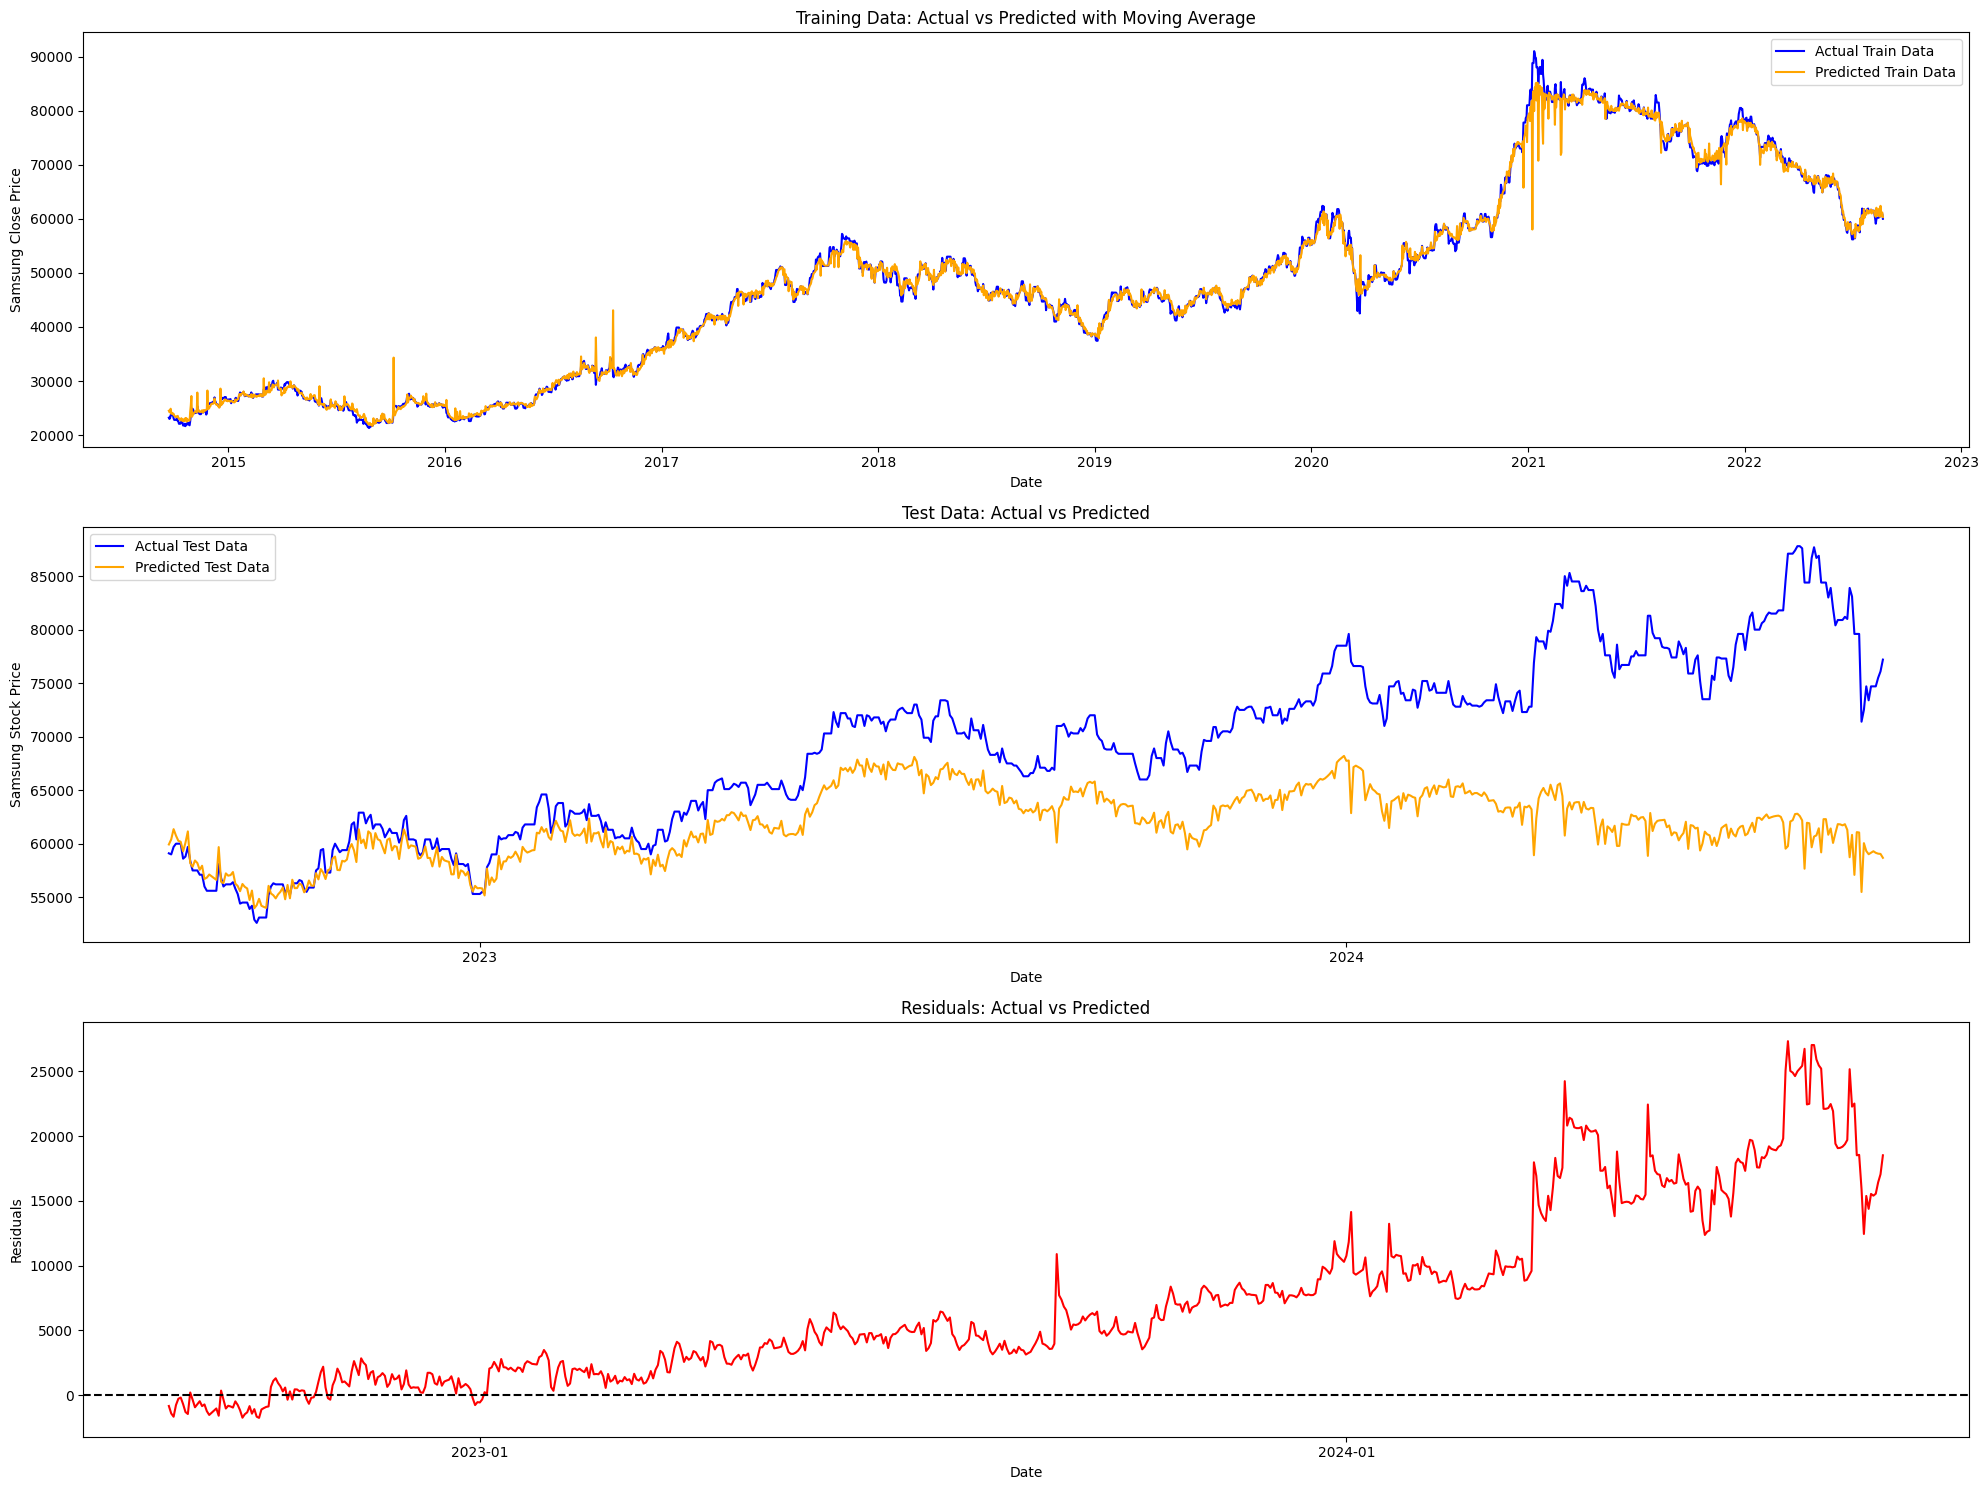

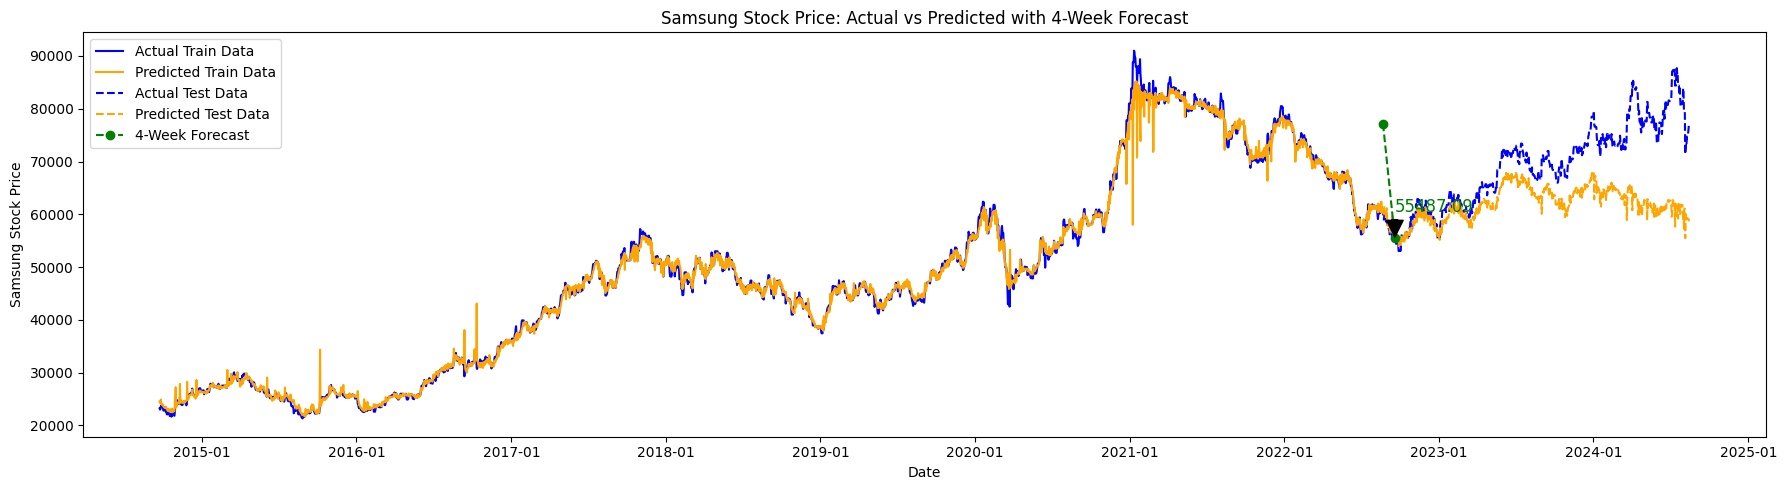

In [58]:
from datetime import timedelta
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

# 마지막 데이터 포인트 추출 및 데이터프레임 생성
last_train_data = X_test[-1:]                                                                                    # 테스트 데이터의 마지막 데이터 포인트 추출
last_train_df = pd.DataFrame(last_train_data, columns=X.columns)

# 스케일링 적용 (StandardScaler 사용)
input_scaled = scaler.transform(last_train_df)

# 4주 후 예측 날짜 계산
last_train_date = data['date'].iloc[len(y_train) - 1]                                                            # 학습 데이터의 마지막 날짜
prediction_date = last_train_date + timedelta(weeks=4)                                                           # 4주 후 날짜 계산

# 최적 모델(best_svr)을 사용하여 예측 수행
predicted_value = best_svr.predict(input_scaled)

# 예측된 값 확인 및 결과 출력
print(f"마지막 학습 날짜: {last_train_date}")
print(f"예측 날짜 (4주 후): {prediction_date}")
print(f"예측된 삼성전자 종가: {predicted_value[0]:.2f}")

# 날짜 데이터 변환 및 정리
data['date'] = pd.to_datetime(data['date'], errors='coerce')
data = data.dropna(subset=['date'])

# 학습 및 테스트 데이터에 대한 예측 수행
y_train_pred = best_svr.predict(X_train)
y_test_pred = best_svr.predict(X_test)

# 시각화: 학습 데이터와 테스트 데이터
plt.figure(figsize=(20, 15))

# 학습 데이터 시각화
plt.subplot(3, 1, 1)
plt.plot(data['date'].iloc[:len(y_train)], y_train.values, label='Actual Train Data', color='blue')
plt.plot(data['date'].iloc[:len(y_train)], y_train_pred, label='Predicted Train Data', color='orange')
plt.title('Training Data: Actual vs Predicted with Moving Average')
plt.xlabel('Date')
plt.ylabel('Samsung Close Price')
plt.legend()
plt.gca().xaxis.set_major_locator(mdates.YearLocator())
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y'))

# 테스트 데이터 시각화
plt.subplot(3, 1, 2)
plt.plot(data['date'].iloc[len(y_train):], y_test.values, label='Actual Test Data', color='blue')
plt.plot(data['date'].iloc[len(y_train):], y_test_pred, label='Predicted Test Data', color='orange')
plt.title('Test Data: Actual vs Predicted')
plt.xlabel('Date')
plt.ylabel('Samsung Stock Price')
plt.legend()
plt.gca().xaxis.set_major_locator(mdates.YearLocator())
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y'))

# 잔차 시각화
residuals = y_test - y_test_pred
plt.subplot(3, 1, 3)
plt.plot(data['date'].iloc[len(y_train):], residuals, label='Residuals', color='red')
plt.axhline(0, color='black', linestyle='--')
plt.title('Residuals: Actual vs Predicted')
plt.xlabel('Date')
plt.ylabel('Residuals')
plt.gca().xaxis.set_major_locator(mdates.YearLocator())
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))

plt.tight_layout()
plt.show()

# 예측 결과를 포함한 시계열 플롯 생성
plt.figure(figsize=(18, 5))
plt.plot(data['date'].iloc[:len(y_train)], y_train.values, label='Actual Train Data', color='blue')
plt.plot(data['date'].iloc[:len(y_train)], y_train_pred, label='Predicted Train Data', color='orange')
plt.plot(data['date'].iloc[len(y_train):], y_test.values, label='Actual Test Data', color='blue', linestyle='--')
plt.plot(data['date'].iloc[len(y_train):], y_test_pred, label='Predicted Test Data', color='orange', linestyle='--')

# 4주 후 예측 결과 시각화
plt.plot([last_train_date, prediction_date],                                                                         # x축 데이터: 마지막 학습 날짜와 예측 날짜
        [data['sc_ss_stock'].iloc[-1], predicted_value[0]],                                                          # y축 데이터: 마지막 실제 값과 예측 값
        label='4-Week Forecast',                                                                                     # 그래프의 범례를 '4-Week Forecast'로 지정
        color='green',                                                                                  
        linestyle='--',                                                                                             
        marker='o')                                                                                                 # 데이터 포인트를 원형 마커로 표시

plt.annotate(f'{predicted_value[0]:.2f}',                                                                           # 주석에 예측 값을 소수점 둘째 자리까지 표시
            xy=(prediction_date, predicted_value[0]),                                                               # 주석이 표시될 위치: 예측 날짜와 예측 값
            xytext=(prediction_date, predicted_value[0] + 5000),                                                    # 주석 텍스트의 위치를 예측 값 위쪽으로 5000 단위 이동
            arrowprops=dict(facecolor='black', shrink=0.05),                                                        # 주석의 화살표 스타일: 검은색으로 설정하고 약간 축소
            fontsize=12,                                                        
            color='green')                                                                                          # 주석 텍스트의 색상을 초록색으로 설정

plt.title('Samsung Stock Price: Actual vs Predicted with 4-Week Forecast')
plt.xlabel('Date')
plt.ylabel('Samsung Stock Price')
plt.legend()
plt.gca().xaxis.set_major_locator(mdates.YearLocator())
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))

plt.tight_layout()
plt.show()

### 10. 산점도 시각화

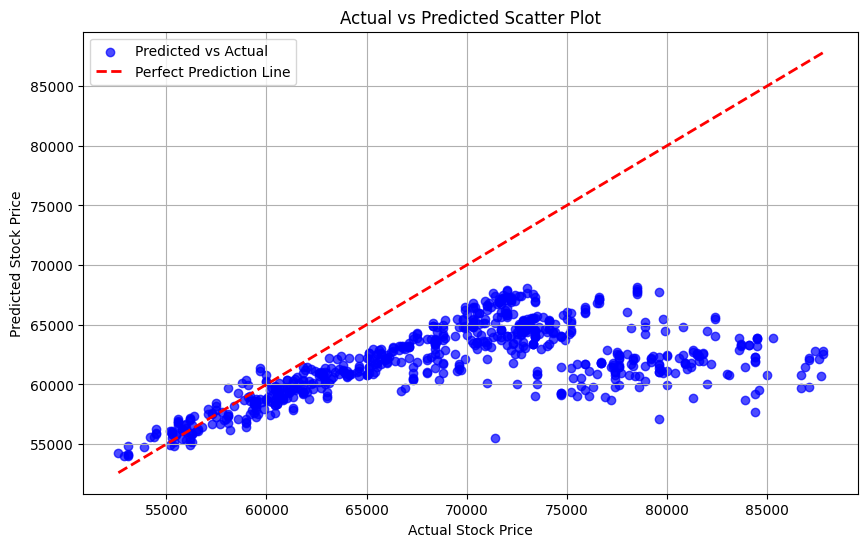

In [59]:
plt.figure(figsize=(10, 6))

# 예측 값과 실제 값의 스케일 복원 (필요한 경우)
if 'y_scaler' in locals():                                                                              # 'y_scaler' 객체가 현재 로컬 변수에 존재하는지 확인
    y_test_actual = y_scaler.inverse_transform(y_test.values.reshape(-1, 1)).flatten()                  # y_test 값을 스케일 복원하여 원래 단위로 변환
                                                                                                        # y_test.values.reshape(-1, 1): y_test를 2차원 배열로 변환
                                                                                                        # y_scaler.inverse_transform: 스케일러를 사용해 원래 값으로 복원
                                                                                                        # flatten(): 결과를 1차원 배열로 변환
    y_test_pred_actual = y_scaler.inverse_transform(y_test_pred.reshape(-1, 1)).flatten()               # y_test_pred 값을 스케일 복원하여 원래 단위로 변환
else:                                                                                                   # 'y_scaler' 객체가 존재하지 않는 경우
    y_test_actual = y_test.values                                                                       # y_test 값을 변환하지 않고 그대로 사용
    y_test_pred_actual = y_test_pred                                                                    # y_test_pred 값을 변환하지 않고 그대로 사용


# 산점도 시각화
plt.scatter(y_test_actual, y_test_pred_actual, alpha=0.7, color='blue', label='Predicted vs Actual')
plt.plot([y_test_actual.min(), y_test_actual.max()], [y_test_actual.min(), y_test_actual.max()], 'r--', lw=2, label='Perfect Prediction Line')
plt.title('Actual vs Predicted Scatter Plot')
plt.xlabel('Actual Stock Price')
plt.ylabel('Predicted Stock Price')
plt.legend()
plt.grid(True)
plt.show()

### 11. 모델 저장

In [49]:
model_filename = 'regression_samsung_svm.joblib'
joblib.dump(scaler, 'regression_samsung_svm_scaler.joblib')
joblib.dump(best_svr, model_filename)
print(f"모델이 '{model_filename}'로 저장되었습니다.")

모델이 'regression_samsung_svm.joblib'로 저장되었습니다.
